# ショックを含む画像の潜在ベクトルの分布を見る

In [24]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")

In [26]:
from vae_preprocess import dataset2d
import img_shows
importlib.reload(img_shows)
from vae_models import ConvVAE
from img_shows import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data_pkls = "../data_pkls/"
pkl_files = [data_pkls + "imgs128_1.pkl", data_pkls + "imgs128_2.pkl", data_pkls + "imgs128_3.pkl"]
dataset2 = dataset2d(pkl_files)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False, drop_last=False)

In [6]:
dates = None
with open(data_pkls + "dates.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
print(len(dates))

19154


## ConvVAEの潜在ベクトル抽出

In [8]:
model = ConvVAE(128)
model.load_state_dict(torch.load("../model_pths/ConvVAE.pth"))
model.eval()
model.to(device)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1))
  (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
  (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 16

In [9]:
hidden_mus = None

In [11]:
with open(data_pkls + "hidden_mus64_convvae.pkl", "rb") as f:
    hidden_mus = pickle.load(f)

## k-meansでクラスタリング: 日付が近いものを除外したい

In [12]:
indices = np.array(list(range(19154))[::22])

In [13]:
num_clusters = 100
s_clustering = KMeans(n_clusters=num_clusters, random_state=10).fit(hidden_mus[indices])
s_labels = s_clustering.labels_

In [14]:
v_label = 50
np.where(s_labels==v_label)[0]

array([293, 332, 358, 409, 670, 721])

In [15]:
poses = indices[np.where(s_labels==v_label)[0]]

<Figure size 432x288 with 0 Axes>

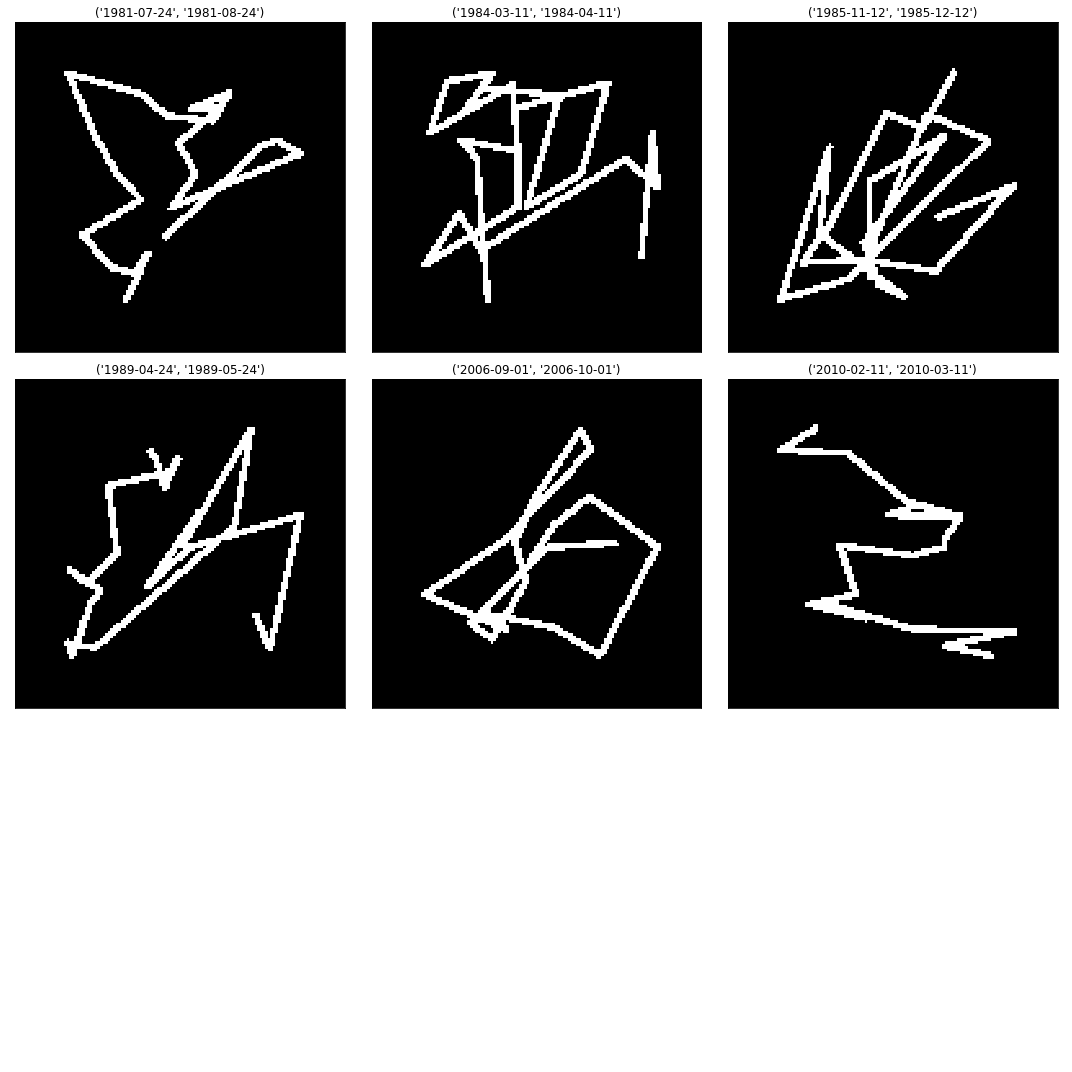

In [17]:
imshow(dataset2, dates, poses)

## 4次元潜在ベクトルをt-SNEで2次元へ

In [18]:
points = TSNE(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

<Figure size 432x288 with 0 Axes>

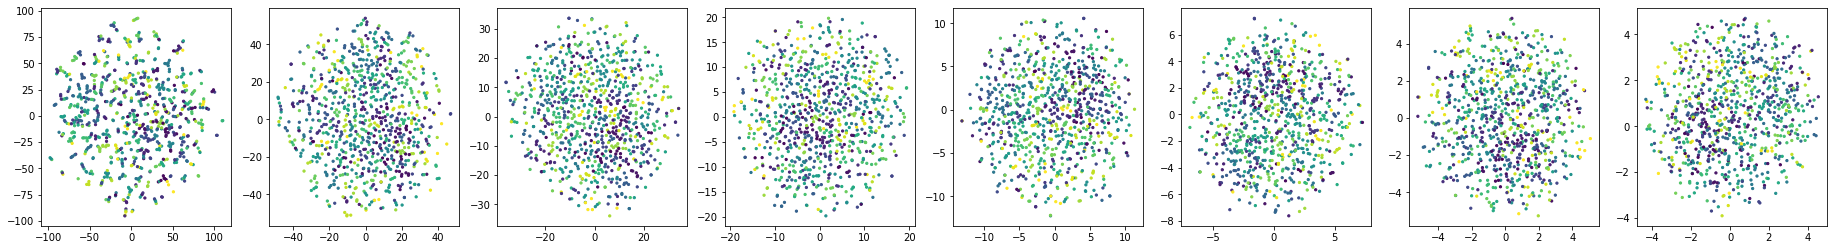

In [27]:
perplexities = [5,25,45, 65,85,105,125,145]
visualize_zsp(hidden_mus[indices], perplexities, labels=s_labels)

<Figure size 432x288 with 0 Axes>

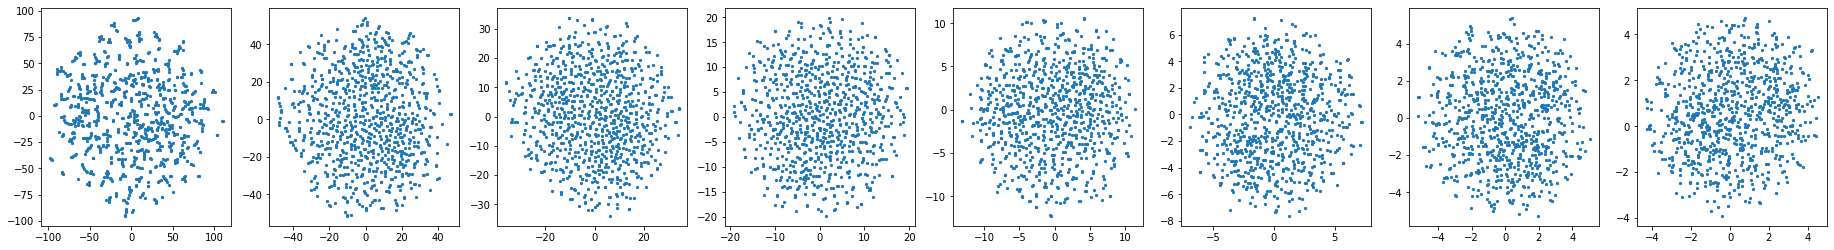

In [28]:
visualize_zsp(hidden_mus[indices], perplexities)

In [66]:
tsne_points = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=2000).fit_transform(hidden_mus[indices])

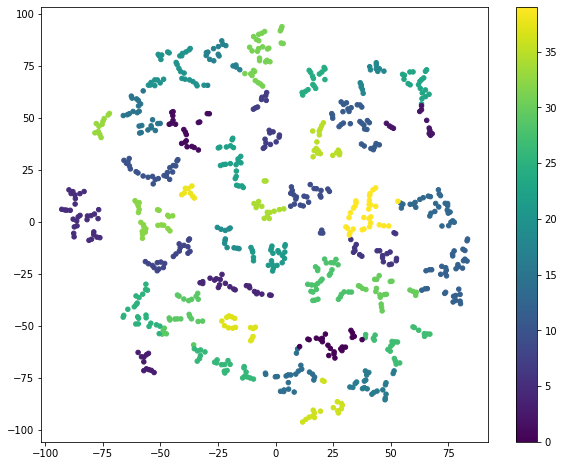

In [112]:
num_clusters = 40 
tsne_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(tsne_points)
tsne_labels = tsne_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(tsne_points[:, 0], tsne_points[:, 1], c=tsne_labels, s=20)
plt.colorbar()

In [107]:
mds_points = MDS(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

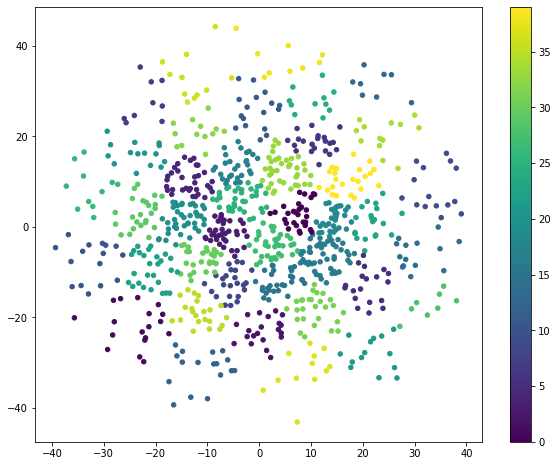

In [110]:
num_clusters = 40 
mds_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(mds_points)
mds_labels = mds_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(mds_points[:, 0], mds_points[:, 1], c=mds_labels, s=20)
plt.colorbar()

In [108]:
se_points = SpectralEmbedding(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

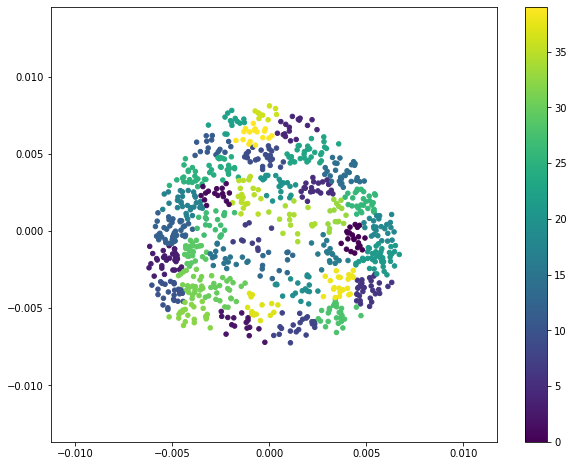

In [111]:
num_clusters = 40 
se_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(se_points)
se_labels = se_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(se_points[:, 0], se_points[:, 1], c=se_labels, s=20)
plt.colorbar()

In [118]:
np.where(tsne_labels==tsne_labels[0])

(array([  0,  43,  59,  70,  88,  92, 107, 118, 123, 128, 143, 145, 159,
        164, 166, 177, 204, 247, 264, 295, 355, 369, 394, 397, 402, 449,
        481, 508, 527, 580, 774, 775]),)

In [119]:
np.where(mds_labels==mds_labels[0])

(array([  0,  40,  59,  63,  90, 116, 118, 186, 207, 258, 273, 299, 311,
        312, 319, 329, 362, 367, 377, 381, 392, 428, 433, 442, 467, 474,
        475, 488, 490, 491, 511, 518, 524, 528, 535, 561, 564, 580, 621,
        680, 838]),)

In [120]:
np.where(se_labels==se_labels[0])

(array([  0,  24,  63, 107, 128, 129, 176, 208, 238, 255, 278, 289, 330,
        347, 374, 379, 380, 405, 407, 477, 484, 498, 499, 512, 534, 536,
        556, 621, 658]),)

## 最も近いものを取ってくる

In [68]:
import heapq
class priority_queue:
    def __init__(self):
        self.key = lambda item: item[0] #アイテムの優先順位を指定
        self.index = 0
        self.data = []

    def push(self, item):
        heapq.heappush(self.data, (self.key(item), self.index, item))
        self.index += 1

    def pop(self):
        return heapq.heappop(self.data)[1]

In [69]:
def get_nearest(pos, hidden_vecs, n = 10):
    t_vec = hidden_vecs[pos]
    pq = priority_queue()
    for i, vec in enumerate(hidden_vecs):
        dist = distance.euclidean(t_vec, vec)
        pq.push([dist, i])
    n_poses = []
    for i in range(n + 1):
        n_poses.append(pq.pop())
    return n_poses[1:]

In [78]:
p = 300
pos = indices[p]
n = 4

<Figure size 432x288 with 0 Axes>

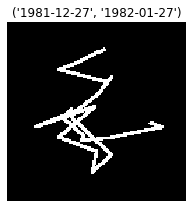

In [79]:
imshow(dataset2, dates, [pos], figsize = (3,3))

[12738  4246  7766 16126]


<Figure size 432x288 with 0 Axes>

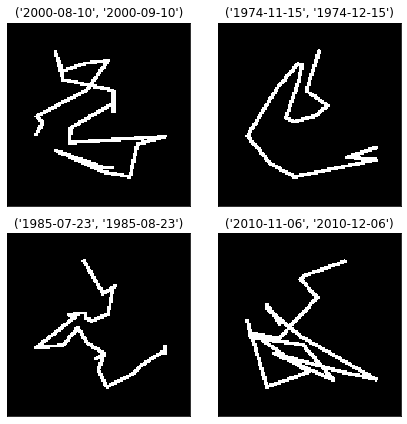

In [80]:
ps = get_nearest(p, hidden_mus[indices], n)
print(indices[ps])
imshow(dataset2, dates, indices[ps], figsize=(6,6))

[12738  7766  4246 16126]


<Figure size 432x288 with 0 Axes>

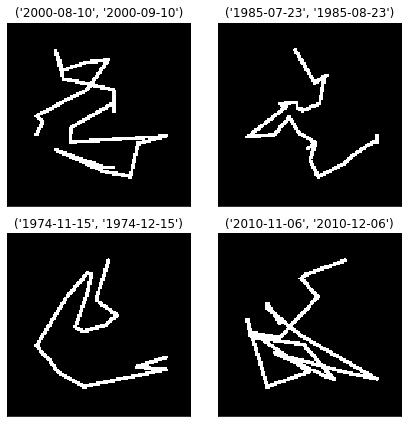

In [84]:
ps = get_nearest(p, tsne_points, n)
print(indices[ps])
imshow(dataset2, dates, indices[ps], figsize=(6,6))

## 絶対位置をどうにかしたいよね

## 変更点

- データを変更？
- モデルを変更 ?
- クラスタリング手法を変更?